In [7]:
# Initializations
import contextlib
import itertools
import math
import os
import random
import time
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, set_random_seed

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

warnings.filterwarnings('ignore')

2.14.0


## Pre-processing: without two angles

In [62]:
N_closest = 50
N_var = 10 ## phi, velocity x/y/z, torque x/y/z, force x/y/z
Re = 100
phi = 5
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u
T_scale = F_scale * D

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB.res"
datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

xyz = np.hstack((x_pos, y_pos, z_pos))
xyz_periodic = np.zeros([N_par,3,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                periodic_index += 1

for i in range(26):
    xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
xyz = xyz[xyz[:,0]>(-Lx/3)]
xyz = xyz[xyz[:,0]<(4*Lx/3)]
xyz = xyz[xyz[:,1]>(-Ly/3)]
xyz = xyz[xyz[:,1]<(4*Ly/3)]
xyz = xyz[xyz[:,2]>(-Ly/3)]
xyz = xyz[xyz[:,2]<(4*Ly/3)]

print(xyz[0,:])

N_p_periodic = np.size(xyz, axis=0)

NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, 4) )

    for i in range(N_p_periodic):
        dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                             ( xyz[i, 1] - xyz[m, 1] )**2 +
                             ( xyz[i, 2] - xyz[m, 2] )**2 )
        dist[i,1] = xyz[i, 0] - xyz[m, 0]
        dist[i,2] = xyz[i, 1] - xyz[m, 1]
        dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:, 1:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)
    
    if m == 0:
        print(dist)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-10] = phi_local[m]
    
    NN_data[m,-9] = x_vel[m]
    NN_data[m,-8] = y_vel[m]
    NN_data[m,-7] = z_vel[m]
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]

if (shape == "cube" and Re == 10 and phi == 10) == True:
    print("We have multiple realizations")
    NN_data_multi = NN_data
    N_case = 4
    for ii in range(1,N_case):
        print(f"======Realization #{ii+1}=======")
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB{ii+1}.res"
        datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
        x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

        datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
        phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

        mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces{ii+1}.csv"
        datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

        x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

        x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

        x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

        xyz = np.hstack((x_pos, y_pos, z_pos))
        xyz_periodic = np.zeros([N_par,3,26])

        periodic_index = 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                for k in [-1,0,1]:
                    if ((i == 0 and j == 0 and k == 0)==False):
                        xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                        periodic_index += 1

        for i in range(26):
            xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
        xyz = xyz[xyz[:,0]>(-Lx/3)]
        xyz = xyz[xyz[:,0]<(4*Lx/3)]
        xyz = xyz[xyz[:,1]>(-Ly/3)]
        xyz = xyz[xyz[:,1]<(4*Ly/3)]
        xyz = xyz[xyz[:,2]>(-Ly/3)]
        xyz = xyz[xyz[:,2]<(4*Ly/3)]

        N_p_periodic = np.size(xyz, axis=0)

        NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

        for m in np.arange(N_par):

            if m%100 == 0 and m!=0:
                print('Particle '+str(m)+' is done!')
        
            dist  = np.zeros( (N_p_periodic, 4) )

            for i in range(N_p_periodic):
                dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                                     ( xyz[i, 1] - xyz[m, 1] )**2 +
                                     ( xyz[i, 2] - xyz[m, 2] )**2 )
                dist[i,1] = xyz[i, 0] - xyz[m, 0]
                dist[i,2] = xyz[i, 1] - xyz[m, 1]
                dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
            dist = dist[ np.argsort( dist[:, 0] ) ]
            dist = dist[:N_closest+1, :]
            dist = dist[1:, 1:]
            dist = dist.flatten()
            dist = dist.reshape(1, -1)

            NN_data[m,:dist.size] = dist
    
            NN_data[m,-10] = phi_local[m]
    
            NN_data[m,-9] = x_vel[m]
            NN_data[m,-8] = y_vel[m]
            NN_data[m,-7] = z_vel[m]
    
            NN_data[m,-6] = x_torque[m]
            NN_data[m,-5] = y_torque[m]
            NN_data[m,-4] = z_torque[m]
    
            NN_data[m,-3] = x_force[m]
            NN_data[m,-2] = y_force[m]
            NN_data[m,-1] = z_force[m]
            
        NN_data_multi = np.vstack((NN_data_multi, NN_data))
        
#     np.savetxt(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data_multi)
# else:
#     np.savetxt(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data)

[ 4.41497 17.6707   4.29189]
[[-1.35792 -0.072    0.0766  -0.50651  0.5863  -1.22     0.65698 -1.6486
   1.18109  0.00502  2.0361  -0.81774  0.82672  0.5893  -2.01945  1.26484
  -1.2682  -1.46135 -2.14738 -0.9783   0.2406   0.39     0.7349   2.29768
   2.15742 -1.1787  -0.54754 -0.84762 -2.353    0.76195 -2.16565  1.7132
   0.04712 -0.95875  1.4959  -2.33389 -2.24597 -1.2582  -1.53621 -2.27017
   0.3922  -2.19328 -0.28937 -1.2438  -2.92049  1.69421  2.6452  -0.62261
  -1.20477  2.2248   1.97396 -1.18017  1.2933   2.81909 -1.77103 -2.8511
  -0.07027  2.66934  0.6403  -2.01584  0.52134 -0.0982  -3.37099  1.4128
   1.1774  -2.91189 -2.34714 -2.1454   2.11812 -2.95217 -2.4879   1.06259
   0.60726  2.7798   2.84956 -0.08379 -2.9823  -2.75469  1.18072  1.0332
   3.75714  4.01797  0.488    0.63999 -0.749   -4.0155   0.65092  0.45681
   1.1049  -3.98679  0.23354 -2.8542   3.0968  -0.58717  3.4879  -2.37599
   4.26377 -0.2453  -0.22913  2.12206 -2.6492  -2.66169 -0.23084 -4.1208
  -1.32136  1.1

## Pre-processing: with two angles

In [45]:
N_closest = 50
N_var = 12 ## angle_phi, angle_psi, phi, velocity x/y/z, torque x/y/z, force x/y/z
Re = 100
phi = 5
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u
T_scale = F_scale * D

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB.res"
datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles.csv"
datafile = pd.read_csv(localpath, delimiter=',')
angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)

mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

xyz = np.hstack((x_pos, y_pos, z_pos))
xyz_periodic = np.zeros([N_par,3,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                periodic_index += 1

for i in range(26):
    xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
xyz = xyz[xyz[:,0]>(-Lx/3)]
xyz = xyz[xyz[:,0]<(4*Lx/3)]
xyz = xyz[xyz[:,1]>(-Ly/3)]
xyz = xyz[xyz[:,1]<(4*Ly/3)]
xyz = xyz[xyz[:,2]>(-Ly/3)]
xyz = xyz[xyz[:,2]<(4*Ly/3)]

N_p_periodic = np.size(xyz, axis=0)

NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, 4) )

    for i in range(N_p_periodic):
        dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                             ( xyz[i, 1] - xyz[m, 1] )**2 +
                             ( xyz[i, 2] - xyz[m, 2] )**2 )
        dist[i,1] = xyz[i, 0] - xyz[m, 0]
        dist[i,2] = xyz[i, 1] - xyz[m, 1]
        dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:, 1:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-12] = angle_phi[m]
    NN_data[m,-11] = angle_psi[m]
    NN_data[m,-10] = phi_local[m]
    
    NN_data[m,-9] = x_vel[m]
    NN_data[m,-8] = y_vel[m]
    NN_data[m,-7] = z_vel[m]
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]

if (shape == "cube" and Re == 10 and phi == 10) == True:
    print("We have multiple realizations")
    NN_data_multi = NN_data
    N_case = 4
    for ii in range(1,N_case):
        print(f"======Realization #{ii+1}=======")
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB{ii+1}.res"
        datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
        x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

        datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
        phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)
        
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles{ii+1}.csv"
        datafile = pd.read_csv(localpath, delimiter=',')
        angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
        angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)

        mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces{ii+1}.csv"
        datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

        x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

        x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

        x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

        xyz = np.hstack((x_pos, y_pos, z_pos))
        xyz_periodic = np.zeros([N_par,3,26])

        periodic_index = 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                for k in [-1,0,1]:
                    if ((i == 0 and j == 0 and k == 0)==False):
                        xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                        periodic_index += 1

        for i in range(26):
            xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
        xyz = xyz[xyz[:,0]>(-Lx/3)]
        xyz = xyz[xyz[:,0]<(4*Lx/3)]
        xyz = xyz[xyz[:,1]>(-Ly/3)]
        xyz = xyz[xyz[:,1]<(4*Ly/3)]
        xyz = xyz[xyz[:,2]>(-Ly/3)]
        xyz = xyz[xyz[:,2]<(4*Ly/3)]

        N_p_periodic = np.size(xyz, axis=0)

        NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

        for m in np.arange(N_par):

            if m%100 == 0 and m!=0:
                print('Particle '+str(m)+' is done!')
        
            dist  = np.zeros( (N_p_periodic, 4) )

            for i in range(N_p_periodic):
                dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                                     ( xyz[i, 1] - xyz[m, 1] )**2 +
                                     ( xyz[i, 2] - xyz[m, 2] )**2 )
                dist[i,1] = xyz[i, 0] - xyz[m, 0]
                dist[i,2] = xyz[i, 1] - xyz[m, 1]
                dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
            dist = dist[ np.argsort( dist[:, 0] ) ]
            dist = dist[:N_closest+1, :]
            dist = dist[1:, 1:]
            dist = dist.flatten()
            dist = dist.reshape(1, -1)

            NN_data[m,:dist.size] = dist
            
            NN_data[m,-12] = angle_phi[m]
            NN_data[m,-11] = angle_psi[m]
    
            NN_data[m,-10] = phi_local[m]
    
            NN_data[m,-9] = x_vel[m]
            NN_data[m,-8] = y_vel[m]
            NN_data[m,-7] = z_vel[m]
    
            NN_data[m,-6] = x_torque[m]
            NN_data[m,-5] = y_torque[m]
            NN_data[m,-4] = z_torque[m]
    
            NN_data[m,-3] = x_force[m]
            NN_data[m,-2] = y_force[m]
            NN_data[m,-1] = z_force[m]
            
        NN_data_multi = np.vstack((NN_data_multi, NN_data))
        
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data_multi)
else:
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data)

Particle 100 is done!
Particle 200 is done!
Particle 300 is done!
Particle 400 is done!
Particle 500 is done!
Particle 600 is done!
Particle 700 is done!
Particle 800 is done!
Particle 900 is done!
Particle 1000 is done!
Particle 1100 is done!


## With all angles

In [ ]:
N_closest = 50
N_var = 14 ## angle_phi, angle_psi, phi, velocity x/y/z, torque x/y/z, force x/y/z
Re = 10
phi = 10
shape = "cube"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u
T_scale = F_scale * D

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB.res"
datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles.csv"
datafile = pd.read_csv(localpath, delimiter=',')
angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)

angle_phi_cos = np.array([math.cos(angle_phi[i]) for i in range(angle_phi.shape[0])]).reshape(-1, 1)
angle_phi_sin = np.array([math.sin(angle_phi[i]) for i in range(angle_phi.shape[0])]).reshape(-1, 1)
angle_psi_cos = np.array([math.cos(angle_psi[i]) for i in range(angle_psi.shape[0])]).reshape(-1, 1)
angle_psi_sin = np.array([math.sin(angle_psi[i]) for i in range(angle_psi.shape[0])]).reshape(-1, 1)

mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

xyz_angles = np.hstack((x_pos, y_pos, z_pos, angle_phi_cos, angle_phi_sin, angle_psi_cos, angle_psi_sin))
xyz_angles_periodic = np.zeros([N_par,7,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_angles_periodic[:,:,periodic_index] = xyz_angles+np.tile([i,j,k,0,0,0,0],[N_par,1])*np.array([Lx,Ly,Lz,0,0,0,0])
                periodic_index += 1

for i in range(26):
    xyz_angles = np.vstack((xyz_angles,xyz_angles_periodic[:,:,i]))
         
xyz_angles = xyz_angles[xyz_angles[:,0]>(-Lx/3)]
xyz_angles = xyz_angles[xyz_angles[:,0]<(4*Lx/3)]
xyz_angles = xyz_angles[xyz_angles[:,1]>(-Ly/3)]
xyz_angles = xyz_angles[xyz_angles[:,1]<(4*Ly/3)]
xyz_angles = xyz_angles[xyz_angles[:,2]>(-Ly/3)]
xyz_angles = xyz_angles[xyz_angles[:,2]<(4*Ly/3)]

N_p_periodic = np.size(xyz_angles, axis=0)

NN_data = np.zeros( (N_par, 7*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, 8) )

    for i in range(N_p_periodic):
        dist[i,0] = np.sqrt( ( xyz_angles[i, 0] - xyz_angles[m, 0] )**2 +
                             ( xyz_angles[i, 1] - xyz_angles[m, 1] )**2 +
                             ( xyz_angles[i, 2] - xyz_angles[m, 2] )**2 )
        dist[i,1] = xyz_angles[i, 0] - xyz_angles[m, 0]
        dist[i,2] = xyz_angles[i, 1] - xyz_angles[m, 1]
        dist[i,3] = xyz_angles[i, 2] - xyz_angles[m, 2]
        dist[i,4:] = xyz_angles[i, 3:]
        
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:, 1:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-14] = angle_phi_cos[m]
    NN_data[m,-13] = angle_phi_sin[m]
    NN_data[m,-12] = angle_psi_cos[m]
    NN_data[m,-11] = angle_psi_sin[m]
    NN_data[m,-10] = phi_local[m]
    
    NN_data[m,-9] = x_vel[m]
    NN_data[m,-8] = y_vel[m]
    NN_data[m,-7] = z_vel[m]
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]

if (shape == "cube" and Re == 10 and phi == 10) == True:
    print("We have multiple realizations")
    NN_data_multi = NN_data
    N_case = 4
    for ii in range(1,N_case):
        print(f"======Realization #{ii+1}=======")
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB{ii+1}.res"
        datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
        x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

        datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
        phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)
        
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles{ii+1}.csv"
        datafile = pd.read_csv(localpath, delimiter=',')
        angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
        angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)
        
        angle_phi_cos = np.array([math.cos(angle_phi[i]) for i in range(angle_phi.shape[0])]).reshape(-1, 1)
        angle_phi_sin = np.array([math.sin(angle_phi[i]) for i in range(angle_phi.shape[0])]).reshape(-1, 1)
        angle_psi_cos = np.array([math.cos(angle_psi[i]) for i in range(angle_psi.shape[0])]).reshape(-1, 1)
        angle_psi_sin = np.array([math.sin(angle_psi[i]) for i in range(angle_psi.shape[0])]).reshape(-1, 1)

        mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces{ii+1}.csv"
        datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

        x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

        x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

        x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

        xyz_angles = np.hstack((x_pos, y_pos, z_pos, angle_phi_cos, angle_phi_sin, angle_psi_cos, angle_psi_sin))
        xyz_angles_periodic = np.zeros([N_par,7,26])

        periodic_index = 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                for k in [-1,0,1]:
                    if ((i == 0 and j == 0 and k == 0)==False):
                        xyz_angles_periodic[:,:,periodic_index] = xyz_angles+np.tile([i,j,k,0,0,0,0],[N_par,1])*np.array([Lx,Ly,Lz,0,0,0,0])
                        periodic_index += 1

        for i in range(26):
            xyz_angles = np.vstack((xyz_angles,xyz_angles_periodic[:,:,i]))

        xyz_angles = xyz_angles[xyz_angles[:,0]>(-Lx/3)]
        xyz_angles = xyz_angles[xyz_angles[:,0]<(4*Lx/3)]
        xyz_angles = xyz_angles[xyz_angles[:,1]>(-Ly/3)]
        xyz_angles = xyz_angles[xyz_angles[:,1]<(4*Ly/3)]
        xyz_angles = xyz_angles[xyz_angles[:,2]>(-Ly/3)]
        xyz_angles = xyz_angles[xyz_angles[:,2]<(4*Ly/3)]

        N_p_periodic = np.size(xyz_angles, axis=0)

        NN_data = np.zeros( (N_par, 7*N_closest + N_var) )

        for m in np.arange(N_par):

            if m%100 == 0 and m!=0:
                print('Particle '+str(m)+' is done!')

            dist  = np.zeros( (N_p_periodic, 8) )

            for i in range(N_p_periodic):
                dist[i,0] = np.sqrt( ( xyz_angles[i, 0] - xyz_angles[m, 0] )**2 +
                                     ( xyz_angles[i, 1] - xyz_angles[m, 1] )**2 +
                                     ( xyz_angles[i, 2] - xyz_angles[m, 2] )**2 )
                dist[i,1] = xyz_angles[i, 0] - xyz_angles[m, 0]
                dist[i,2] = xyz_angles[i, 1] - xyz_angles[m, 1]
                dist[i,3] = xyz_angles[i, 2] - xyz_angles[m, 2]
                dist[i,4:] = xyz_angles[i, 3:]

            dist = dist[ np.argsort( dist[:, 0] ) ]
            dist = dist[:N_closest+1, :]
            dist = dist[1:, 1:]
            dist = dist.flatten()
            dist = dist.reshape(1, -1)

            NN_data[m,:dist.size] = dist

            NN_data[m,-14] = angle_phi_cos[m]
            NN_data[m,-13] = angle_phi_sin[m]
            NN_data[m,-12] = angle_psi_cos[m]
            NN_data[m,-11] = angle_psi_sin[m]
            NN_data[m,-10] = phi_local[m]

            NN_data[m,-9] = x_vel[m]
            NN_data[m,-8] = y_vel[m]
            NN_data[m,-7] = z_vel[m]

            NN_data[m,-6] = x_torque[m]
            NN_data[m,-5] = y_torque[m]
            NN_data[m,-4] = z_torque[m]

            NN_data[m,-3] = x_force[m]
            NN_data[m,-2] = y_force[m]
            NN_data[m,-1] = z_force[m]
            
        NN_data_multi = np.vstack((NN_data_multi, NN_data))
        
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data_multi)
else:
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data)

In [68]:
a = np.array([[[3,3],[2,2],[1,1]],[[4,4],[5,5],[6,6]]])

print(a[0,0,1:])

print(np.append(np.array([0]),np.argsort(a[0,0,1:])+1))
print(a[0,:,:][np.append(np.array([0]),np.argsort(a[0,0,1:])+1)])

[3]
[0 1]
[[3 3]
 [2 2]]


## With vertices

In [5]:
N_closest = 50
N_var = 12 ## angle_phi, angle_psi, phi, velocity x/y/z, torque x/y/z, force x/y/z
Re = 100
phi = 10
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if shape == "tetra":
    N_ver = 4
elif shape == "cube":
    N_ver = 8
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u
T_scale = F_scale * D

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB.res"
datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles.csv"
datafile = pd.read_csv(localpath, delimiter=',')
angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/"+shape+"_phi_"+phi_sys+".csv"
datafile = pd.read_csv(localpath, delimiter=',')
parID = datafile.loc[:,['parID']].values.reshape(-1, 1)
ver_x = datafile.loc[:,['x']].values.reshape(-1, 1)/D
ver_y = datafile.loc[:,['y']].values.reshape(-1, 1)/D
ver_z = datafile.loc[:,['z']].values.reshape(-1, 1)/D
ver_data = np.zeros((x_vel.shape[0],3*N_ver))
for i in range(ver_data.shape[0]):
    for j in range(N_ver):
        ver_data[i,3*j:3*(j+1)] = np.array((ver_x[i*N_ver+j],ver_y[i*N_ver+j],ver_z[i*N_ver+j])).reshape(1,3)

mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                               (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

xyz = np.hstack((x_pos, y_pos, z_pos, ver_data))
xyz_periodic = np.zeros([N_par,3+3*N_ver,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1+N_ver])*np.tile([Lx,Ly,Lz],[1,1+N_ver])
                periodic_index += 1

for i in range(26):
    xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
xyz = xyz[xyz[:,0]>(-Lx/3)]
xyz = xyz[xyz[:,0]<(4*Lx/3)]
xyz = xyz[xyz[:,1]>(-Ly/3)]
xyz = xyz[xyz[:,1]<(4*Ly/3)]
xyz = xyz[xyz[:,2]>(-Ly/3)]
xyz = xyz[xyz[:,2]<(4*Ly/3)]

N_p_periodic = np.size(xyz, axis=0)

NN_data = np.zeros( (N_par, (4+4*N_ver)*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, N_ver+1, 4) )
        
    for i in range(N_p_periodic):
        for j in range(N_ver+1):
            dist[i,j,0] = np.sqrt( ( xyz[i,3*j] - xyz[m,0] )**2 +
                             ( xyz[i,3*j+1] - xyz[m,1] )**2 +
                             ( xyz[i,3*j+2] - xyz[m,2] )**2 )
            dist[i,j,1] = xyz[i,3*j] - xyz[m,0]
            dist[i,j,2] = xyz[i,3*j+1] - xyz[m,1]
            dist[i,j,3] = xyz[i,3*j+2] - xyz[m,2]
        dist[i,:,:] = dist[i,:,:][np.append(np.array([0]),np.argsort(dist[i,1:,0])+1)]
        
    dist = dist.reshape(N_p_periodic, 4*(N_ver+1))
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:,:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-12] = angle_phi[m]
    NN_data[m,-11] = angle_psi[m]
    NN_data[m,-10] = phi_local[m]
    
    NN_data[m,-9] = x_vel[m]
    NN_data[m,-8] = y_vel[m]
    NN_data[m,-7] = z_vel[m]
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]

if (shape == "cube" and Re == 10 and phi == 10) == True:
    print("We have multiple realizations")
    NN_data_multi = NN_data
    N_case = 4
    for ii in range(1,N_case):
        print(f"======Realization #{ii+1}=======")
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB{ii+1}.res"
        datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
        x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

        datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
        phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)
        
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/two_angles{ii+1}.csv"
        datafile = pd.read_csv(localpath, delimiter=',')
        angle_phi = datafile.loc[:,['phi']].values.reshape(-1, 1)
        angle_psi = datafile.loc[:,['psi']].values.reshape(-1, 1)

        mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces{ii+1}.csv"
        datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

        x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

        x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

        x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

        xyz = np.hstack((x_pos, y_pos, z_pos))
        xyz_periodic = np.zeros([N_par,3,26])

        periodic_index = 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                for k in [-1,0,1]:
                    if ((i == 0 and j == 0 and k == 0)==False):
                        xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                        periodic_index += 1

        for i in range(26):
            xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
        xyz = xyz[xyz[:,0]>(-Lx/3)]
        xyz = xyz[xyz[:,0]<(4*Lx/3)]
        xyz = xyz[xyz[:,1]>(-Ly/3)]
        xyz = xyz[xyz[:,1]<(4*Ly/3)]
        xyz = xyz[xyz[:,2]>(-Ly/3)]
        xyz = xyz[xyz[:,2]<(4*Ly/3)]

        N_p_periodic = np.size(xyz, axis=0)

        NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

        for m in np.arange(N_par):

            if m%100 == 0 and m!=0:
                print('Particle '+str(m)+' is done!')
        
            dist  = np.zeros( (N_p_periodic, 4) )

            for i in range(N_p_periodic):
                dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                                     ( xyz[i, 1] - xyz[m, 1] )**2 +
                                     ( xyz[i, 2] - xyz[m, 2] )**2 )
                dist[i,1] = xyz[i, 0] - xyz[m, 0]
                dist[i,2] = xyz[i, 1] - xyz[m, 1]
                dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
            dist = dist[ np.argsort( dist[:, 0] ) ]
            dist = dist[:N_closest+1, :]
            dist = dist[1:, 1:]
            dist = dist.flatten()
            dist = dist.reshape(1, -1)

            NN_data[m,:dist.size] = dist
            
            NN_data[m,-12] = angle_phi[m]
            NN_data[m,-11] = angle_psi[m]
    
            NN_data[m,-10] = phi_local[m]
    
            NN_data[m,-9] = x_vel[m]
            NN_data[m,-8] = y_vel[m]
            NN_data[m,-7] = z_vel[m]
    
            NN_data[m,-6] = x_torque[m]
            NN_data[m,-5] = y_torque[m]
            NN_data[m,-4] = z_torque[m]
    
            NN_data[m,-3] = x_force[m]
            NN_data[m,-2] = y_force[m]
            NN_data[m,-1] = z_force[m]
            
        NN_data_multi = np.vstack((NN_data_multi, NN_data))
        
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}_vertices", NN_data_multi)
else:
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}_vertices", NN_data)

Particle 100 is done!
Particle 200 is done!
Particle 300 is done!
Particle 400 is done!
Particle 500 is done!
Particle 600 is done!
Particle 700 is done!
Particle 800 is done!
Particle 900 is done!
Particle 1000 is done!
Particle 1100 is done!
Particle 1200 is done!
Particle 1300 is done!
Particle 1400 is done!
Particle 1500 is done!
Particle 1600 is done!
Particle 1700 is done!
Particle 1800 is done!
Particle 1900 is done!
Particle 2000 is done!
Particle 2100 is done!
Particle 2200 is done!


## Time-averaged datasets at $Re=100$

In [7]:
N_closest = 50
N_var = 10 ## phi, velocity x/y/z, torque x/y/z, force x/y/z
Re = 100
phi = 5
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
    Lx = (0.025-0.002)/D
    Ly = (0.024875-0.002)/D
    Lz = (0.0248125-0.002)/D
else:
    phi_sys = "0p2"
    N_par = 2197
    Lx = (0.01992-0.002)/D
    Ly = (0.01992-0.002)/D
    Lz = (0.01992-0.002)/D
    
if Re == 1:
    mu = 0.02
elif Re == 10:
    mu = 0.002 
else:
    mu = 0.0002     

F_scale = 3.*np.pi*mu*D*u
T_scale = F_scale * D

localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB.res"
datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                      datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par*10:]

x_pos, y_pos, z_pos = datafile.iloc[-N_par:, 2].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[-N_par:, 3].to_numpy().reshape(-1,1)/D,\
                      datafile.iloc[-N_par:, 4].to_numpy().reshape(-1,1)/D,

x_force = np.zeros((N_par,1))
y_force = np.zeros((N_par,1))
z_force = np.zeros((N_par,1))
x_torque = np.zeros((N_par,1))
y_torque = np.zeros((N_par,1))
z_torque = np.zeros((N_par,1))

for i in range(10):
    x_force += (datafile.iloc[i*N_par:(i+1)*N_par,11].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,14].to_numpy()).reshape(-1,1)/(10*F_scale)
    y_force += (datafile.iloc[i*N_par:(i+1)*N_par,12].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,15].to_numpy()).reshape(-1,1)/(10*F_scale)
    z_force += (datafile.iloc[i*N_par:(i+1)*N_par,13].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,16].to_numpy()).reshape(-1,1)/(10*F_scale)

    x_torque += (datafile.iloc[i*N_par:(i+1)*N_par,17].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,20].to_numpy()).reshape(-1,1)/(10*T_scale)
    y_torque += (datafile.iloc[i*N_par:(i+1)*N_par,18].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,21].to_numpy()).reshape(-1,1)/(10*T_scale)
    z_torque += (datafile.iloc[i*N_par:(i+1)*N_par,19].to_numpy()+datafile.iloc[i*N_par:(i+1)*N_par,22].to_numpy()).reshape(-1,1)/(10*T_scale)

xyz = np.hstack((x_pos, y_pos, z_pos))
xyz_periodic = np.zeros([N_par,3,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                periodic_index += 1

for i in range(26):
    xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
xyz = xyz[xyz[:,0]>(-Lx/3)]
xyz = xyz[xyz[:,0]<(4*Lx/3)]
xyz = xyz[xyz[:,1]>(-Ly/3)]
xyz = xyz[xyz[:,1]<(4*Ly/3)]
xyz = xyz[xyz[:,2]>(-Ly/3)]
xyz = xyz[xyz[:,2]<(4*Ly/3)]

N_p_periodic = np.size(xyz, axis=0)

NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, 4) )

    for i in range(N_p_periodic):
        dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                             ( xyz[i, 1] - xyz[m, 1] )**2 +
                             ( xyz[i, 2] - xyz[m, 2] )**2 )
        dist[i,1] = xyz[i, 0] - xyz[m, 0]
        dist[i,2] = xyz[i, 1] - xyz[m, 1]
        dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:, 1:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-10] = phi_local[m]
    
    NN_data[m,-9] = x_vel[m]
    NN_data[m,-8] = y_vel[m]
    NN_data[m,-7] = z_vel[m]
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]

if (shape == "cube" and Re == 10 and phi == 10) == True:
    print("We have multiple realizations")
    NN_data_multi = NN_data
    N_case = 4
    for ii in range(1,N_case):
        print(f"======Realization #{ii+1}=======")
        localpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/fieldVolumeAverageAroundRB{ii+1}.res"
        datafile = pd.read_csv(localpath, header=None, skiprows=1, skipfooter=N_par+1, delimiter='\t')
        x_vel, y_vel, z_vel = datafile.iloc[:, 0].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 1].to_numpy().reshape(-1,1)/u,\
                              datafile.iloc[:, 2].to_numpy().reshape(-1,1)/u,

        datafile = pd.read_csv(localpath, header=None, skiprows=N_par+2, delimiter='\t')
        phi_local = datafile.iloc[:, 0].to_numpy().reshape(-1,1)

        mainpath = "Datasets/Platonic_Data/"+shape+"_phi_"+phi_sys+f"_Re_{Re}/particle_forces{ii+1}.csv"
        datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

        x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 3].to_numpy().reshape(-1,1)/D,\
                              datafile.iloc[:, 4].to_numpy().reshape(-1,1)/D,

        x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1)/F_scale,\
                                    (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)/F_scale

        x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1)/T_scale,\
                                       (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)/T_scale

        xyz = np.hstack((x_pos, y_pos, z_pos))
        xyz_periodic = np.zeros([N_par,3,26])

        periodic_index = 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                for k in [-1,0,1]:
                    if ((i == 0 and j == 0 and k == 0)==False):
                        xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                        periodic_index += 1

        for i in range(26):
            xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
         
        xyz = xyz[xyz[:,0]>(-Lx/3)]
        xyz = xyz[xyz[:,0]<(4*Lx/3)]
        xyz = xyz[xyz[:,1]>(-Ly/3)]
        xyz = xyz[xyz[:,1]<(4*Ly/3)]
        xyz = xyz[xyz[:,2]>(-Ly/3)]
        xyz = xyz[xyz[:,2]<(4*Ly/3)]

        N_p_periodic = np.size(xyz, axis=0)

        NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

        for m in np.arange(N_par):

            if m%100 == 0 and m!=0:
                print('Particle '+str(m)+' is done!')
        
            dist  = np.zeros( (N_p_periodic, 4) )

            for i in range(N_p_periodic):
                dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                                     ( xyz[i, 1] - xyz[m, 1] )**2 +
                                     ( xyz[i, 2] - xyz[m, 2] )**2 )
                dist[i,1] = xyz[i, 0] - xyz[m, 0]
                dist[i,2] = xyz[i, 1] - xyz[m, 1]
                dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
            dist = dist[ np.argsort( dist[:, 0] ) ]
            dist = dist[:N_closest+1, :]
            dist = dist[1:, 1:]
            dist = dist.flatten()
            dist = dist.reshape(1, -1)

            NN_data[m,:dist.size] = dist
    
            NN_data[m,-10] = phi_local[m]
    
            NN_data[m,-9] = x_vel[m]
            NN_data[m,-8] = y_vel[m]
            NN_data[m,-7] = z_vel[m]
    
            NN_data[m,-6] = x_torque[m]
            NN_data[m,-5] = y_torque[m]
            NN_data[m,-4] = z_torque[m]
    
            NN_data[m,-3] = x_force[m]
            NN_data[m,-2] = y_force[m]
            NN_data[m,-1] = z_force[m]
            
        NN_data_multi = np.vstack((NN_data_multi, NN_data))
        
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets/Average_"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data_multi)
else:
    np.savetxt(f"Datasets/Platonic_Data/NN_Datasets/Average_"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}", NN_data)

Particle 100 is done!
Particle 200 is done!
Particle 300 is done!
Particle 400 is done!
Particle 500 is done!
Particle 600 is done!
Particle 700 is done!
Particle 800 is done!
Particle 900 is done!
Particle 1000 is done!
Particle 1100 is done!


## PINN drag - without local properties

In [5]:
N_closest = 50
N_var = 12
Re = 100
phi = 5
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"

N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -3].reshape(-1,1)

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}" +
                        f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    Y_train = np.vstack((Y_train,Y_train))
    Y_train = np.vstack((Y_train,Y_train))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')

        #     shared_layer_4 = Dense(N_neurons,
        #                      activation=my_act,
        #                      kernel_initializer=glorot,
        #                      bias_initializer=initializers.Constant(0.1),
        #                      name='shared_layer_4')

    def summation(p_tensor):
        '''
        Each individual neighbor contribution to drag is
        always directed along the x-direction.
        '''
        # Drag _______________________________________
        return tf.reduce_sum(p_tensor, axis=1, keepdims=True)

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(shared_layer_3(
            shared_layer_2(shared_layer_1(input_list[p]))))

    # Concatenate the output of each neighbor===============
    concat = Concatenate()(
        [Lambda(summation, name=f'summation{j}')(out_list[j])
            for j in range(N_closest)])

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()

    output_layer = Dense(1,
                        activation='linear',
                        kernel_constraint=nonneg,
                        name='out_x',
                        use_bias=False)(concat)

    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list, outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=0.0005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=0.001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list, Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        callbacks=[EarlyStop, LRDecay, ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Simple_Drag_model_{q}.h5')
    os.chdir("../../")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Simple_Drag_true.npy',Y_test_plot)
np.save(f'Simple_Drag_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re = 100 and phi =  10%
(2292, 150) (2292, 1)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
230/230 [==============================] - 2s 7ms/step
Training R^2	= 0.665
CPU time: 56.490 for     7332 datapoints
15/15 [==============================] - 0s 8ms/step
Test R^2	= 0.592
CPU time: 0.526 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
230/230 [==============================] - 2s 6ms/step
Training R^2	= 0.652
CPU time: 29.243 for     7332 datapoints
15/15 [==============================] - 0s 7ms/step
Test R^2	= 0.654
CPU time: 0.232 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
230/230 [==============================] - 2s 6ms/step
Training R^2	= 0.665
CPU time: 3.463 for     7336 datapoints
15/15 [==============================] - 0s 11ms/step
Test R^2	= 0.615
CPU time: 0.494 for 

## Fully-connected drag - with local properties

In [56]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
N_closest = 50
N_var = 12
Re = 10
phi = 10
shape = "icosa"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
    
if shape == "tetra":
    N_ver = 4
elif shape == "cube":
    N_ver = 8
    
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}_vertices"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values

N_closest = 1

X_in = dataset[:, :3*N_closest]
Y_in = dataset[:, -3].reshape(-1,1)
V_in = dataset[:, -10:-6]

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 10  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 4e-4  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}"
                        # + f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    
    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')
    
    if q == 1:
    
        X_train_list = []
        X_test_list = []
        p_input_list = []
        p_out_list = []

        X_train, X_test = X_in[train_index], X_in[test_index]
        Y_train, Y_test = Y_in[train_index], Y_in[test_index]

        # Training =======================================

        # neural network _______________________________________
        r_input = Input(shape=X_train.shape[1], name='r_in')

        layer = Dense(N_neurons, activation='tanh', name='layer_1')(r_input)
        layer = Dense(N_neurons, activation='tanh', name='layer_2')(layer)
        layer = Dense(N_neurons, activation='tanh', name='layer_3')(layer)

        nonneg = tf.keras.constraints.NonNeg()

        # output_layer = Dense(1,
        #                     activation='linear',
        #                     # kernel_constraint=nonneg,
        #                     name='out_x',
        #                     use_bias=False)(layer)

        output_layer = Dense(1,activation='relu',name='out_x')(layer)

        # Neural net fitting _______________________________________

        def R2(y_true, y_pred):
            '''
            This function computes the R^2 for the callback function.
            '''
            SS_res =  K.sum(K.square(y_true - y_pred)) 
            SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
            return 1 - SS_res / (SS_tot + K.epsilon())

        model = Model(inputs=[r_input],outputs=output_layer)

        myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        model.compile(loss='msle', optimizer=myoptimizer, metrics=R2)

        history = model.fit(
                            [X_train],
                            Y_train,

                            validation_split=0.2,
                            shuffle=True,
                            epochs=epochs,
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=[ten_epochs],
                            )

        # Training set results==================================
        start_time = time.perf_counter()
        Y_pred = model.predict(X_train)
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
        Total_time_train += end_time-start_time
        train_scores.append(r2_score(Y_train, Y_pred))

        # Testing =======================================
        start_time = time.perf_counter()
        Y_pred_test = model.predict(X_test)
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
        Total_time_test += end_time-start_time
        test_scores.append(r2_score(Y_test, Y_pred_test))

        # dataset for plotting all the tests together
        X_test_plot = np.vstack((X_test_plot, X_test))
        Y_test_plot = np.vstack((Y_test_plot, Y_test))
        Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

        if os.path.isdir(my_path) == False:
            os.makedirs(my_path)

        os.chdir(my_path)
        model.save(f'Simple_Drag_model_{q}.h5')
        os.chdir("../../../")

        print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Simple_Drag_true.npy',Y_test_plot)
np.save(f'Simple_Drag_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re =  10 and phi =  10%
(2292, 6) (2292, 1) (2292, 4)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
58/58 [==============================] - 0s 752us/step
Training R^2	= 0.320
CPU time: 0.133 for     1833 datapoints
15/15 [==============================] - 0s 767us/step
Test R^2	= 0.164
CPU time: 0.060 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 4+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 5+++++++++++++++++++++++++
Overall performance:
<Average Train R^2> = 0.320
<Average Test R^2> = 0.164
<Average Train time> = 0.027
<Average Test time> = 0.012

Total number of model parameters: 601

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 r_in (InputLayer)           [(None, 6)]      

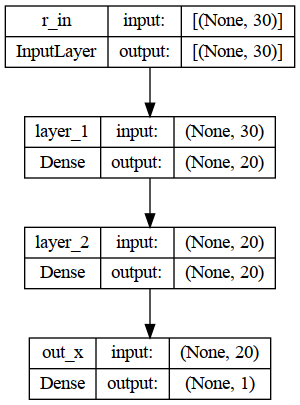

In [32]:
plot_model(model, show_layer_names=True, show_shapes=True)

In [85]:
import itertools

a = [1,2,3,4,5,6]
b = list(itertools.chain.from_iterable(a[3*p+1:3*p+3] for p in range(2)))
print(b)

[2, 3, 5, 6]


## PINN drag - with local properties - with vertices

In [37]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
N_closest = 50
N_var = 12
Re = 100
phi = 10
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
    
if shape == "tetra":
    N_ver = 4
elif shape == "cube":
    N_ver = 8
    
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}_vertices"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}_vertices",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]

Re = 10
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
Y_in = dataset[:, -3].reshape(-1,1)
V_in = dataset[:, -10:-6]

X_in = X_in[:,list(itertools.chain.from_iterable([list(range(4*(N_ver+1)*i+4,4*(N_ver+1)*i+4*(N_ver+1))) for i in range(N_closest)]))]
X_in = X_in[:,list(itertools.chain.from_iterable([list(range(4*i+1,4*i+4)) for i in range(N_closest*(N_ver))]))]
# X_in = X_in[:,list(itertools.chain.from_iterable([list(range(4*(N_ver+1)*i+1,4*(N_ver+1)*i+4)) for i in range(N_closest)]))]

# print(X_in[0,:])

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

# N_closest = 40

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
epochs = 500  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}"
                        # + f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')
    N_ver = 4

    if q == 1:

        # Split the training and test sets=====================
        X_train_list = []
        X_test_list = []
        input_list = []
        out_list = []
        X_train, X_test = X_in[train_index], X_in[test_index]
        Y_train, Y_test = Y_in[train_index], Y_in[test_index]
        V_train, V_test = V_in[train_index], V_in[test_index]

        # X_train_tmp = X_train.copy()
        # for p in range(N_closest):
        #     X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
        # X_train = np.vstack((X_train,X_train_tmp))
        # X_train_tmp = X_train.copy()
        # for p in range(N_closest):
        #     X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
        # X_train = np.vstack((X_train,X_train_tmp))
        
        X_train_tmp = X_train.copy()
        for p in range(N_closest*N_ver):
            X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
        X_train = np.vstack((X_train,X_train_tmp))
        X_train_tmp = X_train.copy()
        for p in range(N_closest):
            X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
        X_train = np.vstack((X_train,X_train_tmp))

        Y_train = np.vstack((Y_train,Y_train))
        Y_train = np.vstack((Y_train,Y_train))

        V_train_tmp = V_train.copy()
        V_train_tmp[:,-2] = -V_train_tmp[:,-2]
        V_train = np.vstack((V_train,V_train_tmp))
        V_train_tmp = V_train.copy()
        V_train_tmp[:,-1] = -V_train_tmp[:,-1]
        V_train = np.vstack((V_train,V_train_tmp))

        # Initialization========================================
        glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

        # Middle layers=========================================
        shared_layer_1 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_1')

        shared_layer_2 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_2')

        shared_layer_3 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_3')

        V_input = Input(shape=V_train.shape[1], name='V_in')

        V_layer1 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer1')(V_input)

        V_layer2 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer2')(V_layer1)

        V_layer3 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer3')(V_layer2)

        def summation(p_tensor):
            '''
            Each individual neighbor contribution to drag is
            always directed along the x-direction.
            '''
            # Drag _______________________________________
            return tf.reduce_sum(p_tensor, axis=1, keepdims=True)

        for p in range(0, N_closest):
            # Split by each neighbor
            X_train_list.append(X_train[:, 3*N_ver*p:3*N_ver*p+3*N_ver])

            # Input layer=======================================
            input_list.append(Input(shape=3*N_ver, name=f'nghb_{p}'))

            # Output of each neighbor===========================
            out_list.append(tf.keras.layers.Multiply()([shared_layer_3(
                shared_layer_2(shared_layer_1(input_list[p]))),V_layer3]))
            
            # out_list.append(tf.keras.layers.Multiply()([shared_layer_2(shared_layer_1(input_list[p])),V_layer2]))
            
        # print(X_train_list[0])

        # Concatenate the output of each neighbor===============
        concat = Concatenate()(
            [Lambda(summation, name=f'summation{j}')(out_list[j])
                for j in range(N_closest)])

        # Output layer==========================================
        nonneg = tf.keras.constraints.NonNeg()

        output_layer = Dense(1,
                            activation='linear',
                            kernel_constraint=nonneg,
                            name='out_x',
                            use_bias=False)(concat)
        
        # output_layer = Dense(1,
        #                     activation=my_act,
        #                     name='out_x',
        #                     use_bias=False)(concat)

        # Evaluation metric: R^2 score==========================
        def R2_val(y_true, y_pred):
            '''
            This function computes the R^2 for the callback function.
            '''
            SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
            SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
            return 1 - SS_res / SS_tot

        def R2(y_true, y_pred):
            '''
            This function computes the R^2 for the callback function.
            '''
            SS_res = K.sum(K.square(y_true - y_pred)) 
            SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
            return 1 - SS_res / SS_tot

        # Neural network description============================
        model = Model(inputs=input_list+[V_input], outputs=output_layer)
        myoptimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
        EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=5e-4)
        LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=1e-3)
        model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

        # Neural network fitting================================
        history = model.fit(
            X_train_list + [V_train], Y_train,

            validation_split=0.2,
            shuffle=True,
            epochs=epochs,
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[EarlyStop, LRDecay, ten_epochs],
            # callbacks=[ten_epochs]
        )

        # Training set results==================================
        start_time = time.perf_counter()
        Y_pred = model.predict(X_train_list+[V_train])
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
        Total_time_train += end_time-start_time
        train_scores.append(r2_score(Y_train, Y_pred))

        # Test set results======================================
        for p in range(0, N_closest):
            X_test_list.append(X_test[:, 3*N_ver*p:3*N_ver*p+3*N_ver])

        start_time = time.perf_counter()
        Y_pred_test = model.predict(X_test_list+[V_test])
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
        Total_time_test += end_time-start_time
        test_scores.append(r2_score(Y_test, Y_pred_test))

        # Dataset for plotting all the tests together
        X_test_plot = np.vstack((X_test_plot, X_test))
        Y_test_plot = np.vstack((Y_test_plot, Y_test))
        Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

        if os.path.isdir(my_path) == False:
            os.makedirs(my_path)

        os.chdir(my_path)
        model.save(f'Drag_model_{q}.h5')
        os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

        print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Drag_true.npy',Y_test_plot)
np.save(f'Drag_pred.npy',Y_pred_test_plot)
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re =  10 and phi =  10%
(2292, 600) (2292, 1) (2292, 4)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
230/230 [==============================] - 1s 2ms/step
Training R^2	= 0.808
CPU time: 1.153 for     7332 datapoints
15/15 [==============================] - 0s 2ms/step
Test R^2	= 0.773
CPU time: 0.171 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 4+++++++++++++++++++++++++
+++++++++++++++++++++++++Fold 5+++++++++++++++++++++++++
Overall performance:
<Average Train R^2> = 0.808
<Average Test R^2> = 0.773
<Average Train time> = 0.231
<Average Test time> = 0.034

Total number of model parameters: 2090

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected 

## PINN drag - with all angles

In [33]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
N_closest = 50
N_var = 14
N_ngb_var = 7
Re = 10
phi = 10
shape = "cube"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets_all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -3].reshape(-1,1)
V_in = dataset[:, -10:-6]

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

N_closest = 20

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 30  # number of neurons at each layer
epochs = 200  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}"
                        # + f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    if q == 1:

        # Split the training and test sets=====================
        X_train_list = []
        X_test_list = []
        input_list = []
        out_list = []
        X_train, X_test = X_in[train_index], X_in[test_index]
        Y_train, Y_test = Y_in[train_index], Y_in[test_index]
        V_train, V_test = V_in[train_index], V_in[test_index]

    #     X_train_tmp = X_train.copy()
    #     for p in range(N_closest):
    #         X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    #     X_train = np.vstack((X_train,X_train_tmp))
    #     X_train_tmp = X_train.copy()
    #     for p in range(N_closest):
    #         X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    #     X_train = np.vstack((X_train,X_train_tmp))

    #     Y_train = np.vstack((Y_train,Y_train))
    #     Y_train = np.vstack((Y_train,Y_train))

    #     V_train_tmp = V_train.copy()
    #     V_train_tmp[:,-2] = -V_train_tmp[:,-2]
    #     V_train = np.vstack((V_train,V_train_tmp))
    #     V_train_tmp = V_train.copy()
    #     V_train_tmp[:,-1] = -V_train_tmp[:,-1]
    #     V_train = np.vstack((V_train,V_train_tmp))

        # Initialization========================================
        glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

        # Middle layers=========================================
        shared_layer_1 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_1')

        shared_layer_2 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_2')

        shared_layer_3 = Dense(N_neurons,
                                activation=my_act,
                                kernel_initializer=glorot,
                                bias_initializer=initializers.Constant(0.1),
                                name='shared_layer_3')

        V_input = Input(shape=V_train.shape[1], name='V_in')

        V_layer1 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer1')(V_input)

        V_layer2 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer2')(V_layer1)

        V_layer3 = Dense(N_neurons,
                        activation=my_act,
                        kernel_initializer=glorot,
                        bias_initializer=initializers.Constant(0.1),
                        name='V_layer3')(V_layer2)

        def summation(p_tensor):
            '''
            Each individual neighbor contribution to drag is
            always directed along the x-direction.
            '''
            # Drag _______________________________________
            return tf.reduce_sum(p_tensor, axis=1, keepdims=True)

        for p in range(0, N_closest):
            # Split by each neighbor
            X_train_list.append(X_train[:, N_ngb_var*p:N_ngb_var*p+N_ngb_var])

            # Input layer=======================================
            input_list.append(Input(shape=N_ngb_var, name=f'nghb_{p}'))

            # Output of each neighbor===========================
            out_list.append(tf.keras.layers.Multiply()([shared_layer_3(
                shared_layer_2(shared_layer_1(input_list[p]))),V_layer3]))

        # Concatenate the output of each neighbor===============
        concat = Concatenate()(
            [Lambda(summation, name=f'summation{j}')(out_list[j])
                for j in range(N_closest)])

        # Output layer==========================================
        nonneg = tf.keras.constraints.NonNeg()

        output_layer = Dense(1,
                            activation='linear',
                            kernel_constraint=nonneg,
                            name='out_x',
                            use_bias=False)(concat)

        # Evaluation metric: R^2 score==========================
        def R2_val(y_true, y_pred):
            '''
            This function computes the R^2 for the callback function.
            '''
            SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
            SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
            return 1 - SS_res / SS_tot

        def R2(y_true, y_pred):
            '''
            This function computes the R^2 for the callback function.
            '''
            SS_res = K.sum(K.square(y_true - y_pred)) 
            SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
            return 1 - SS_res / SS_tot

        # Neural network description============================
        model = Model(inputs=input_list+[V_input], outputs=output_layer)
        myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=5e-4)
        LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=1e-3)
        model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

        # Neural network fitting================================
        history = model.fit(
            X_train_list + [V_train], Y_train,

            validation_split=0.2,
            shuffle=True,
            epochs=epochs,
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[EarlyStop, LRDecay, ten_epochs],
            # callbacks=[ten_epochs]
        )

        # Training set results==================================
        start_time = time.perf_counter()
        Y_pred = model.predict(X_train_list+[V_train])
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
        Total_time_train += end_time-start_time
        train_scores.append(r2_score(Y_train, Y_pred))

        # Test set results======================================
        for p in range(0, N_closest):
            X_test_list.append(X_test[:, N_ngb_var*p:N_ngb_var*p+N_ngb_var])

        start_time = time.perf_counter()
        Y_pred_test = model.predict(X_test_list+[V_test])
        end_time = time.perf_counter()
        print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
        print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
        Total_time_test += end_time-start_time
        test_scores.append(r2_score(Y_test, Y_pred_test))

        # Dataset for plotting all the tests together
        X_test_plot = np.vstack((X_test_plot, X_test))
        Y_test_plot = np.vstack((Y_test_plot, Y_test))
        Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

        if os.path.isdir(my_path) == False:
            os.makedirs(my_path)

        os.chdir(my_path)
        model.save(f'Drag_model_{q}.h5')
        os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

        print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Drag_true.npy',Y_test_plot)
np.save(f'Drag_pred.npy',Y_pred_test_plot)
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re =  10 and phi =  10%
(9168, 350) (9168, 1) (9168, 4)


SyntaxError: keyword argument repeated: callbacks (1748292614.py, line 236)

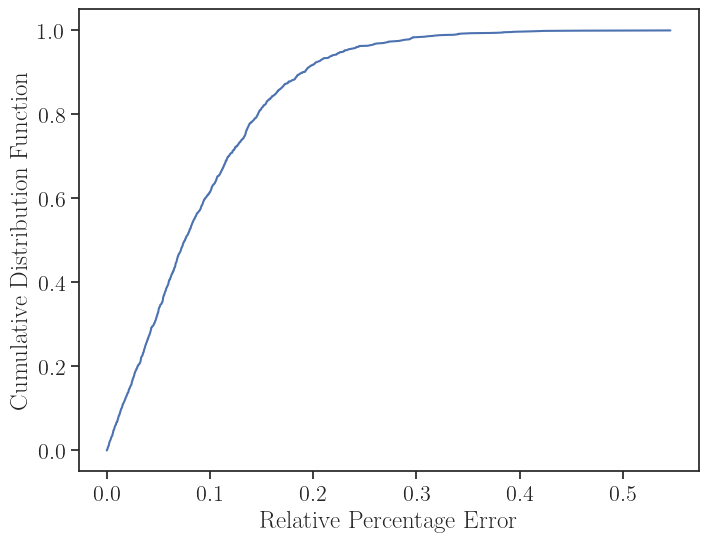

In [105]:
# import seaborn as sns
from matplotlib import rc

warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

# sns.set_theme(style='white')
# sns.set(style="ticks")

# sns.distplot(x=Y_test, bins=10,color='blue')
# sns.distplot(x=Y_pred_test, bins=10,color='red')


# my_Y = np.array([abs((Y_test[i]-Y_pred_test[i])/(Y_test[i])) for i in range(Y_test.shape[0])]).reshape(-1,1)
# my_Y = my_Y[my_Y<1]
# ax1.hist(x=my_Y, bins=20,color='blue',alpha=0.5,weights=np.ones(len(my_Y)) / len(my_Y))
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.set_xlabel(r"Relative Percentage Error",fontsize=18)
# ax1.set_ylabel(r"PDF",fontsize=18)
# status = "_in_sincos.png"
# # status = "_without_angles.png"
# name = "PDF_"+shape+f"_Re_{Re}_phi_"+phi_sys+status
# fig.savefig(name, bbox_inches="tight")


my_mean = np.mean(Y_test)
my_Y = np.array([abs((Y_test[i]-Y_pred_test[i])/(Y_test[i])) for i in range(Y_test.shape[0])]).reshape(-1,1)
my_Y = my_Y[my_Y<1]

data_sorted = np.sort(my_Y)
p = 1. * np.arange(len(my_Y)) / (len(my_Y) - 1)
ax1 = plt.subplot(111)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_xlabel(r"Relative Percentage Error",fontsize=18)
ax1.set_ylabel(r"Cumulative Distribution Function",fontsize=18)
ax1.plot(data_sorted, p)
status = "_in_sincos.png"
# status = "_without_angles.png"
name = "CDF_"+shape+f"_Re_{Re}_phi_"+phi_sys+status
fig.savefig(name, bbox_inches="tight")

# ax1.plot(history.history['loss'])
# ax1.plot(history.history['val_loss'])
# ax1.set_ylim([0,2])
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.set_xlabel(r"Epoch",fontsize=18)
# ax1.set_ylabel(r"Loss",fontsize=18)
# # status = "_without_angles.png"
# status = "_in_sincos.png"
# name = "Loss_"+shape+f"_Re_{Re}_phi_"+phi_sys+status
# fig.savefig(name, bbox_inches="tight")

## PINN drag - with two angles

In [4]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
N_closest = 50
N_var = 12
Re = 10
phi = 10
shape = "cube"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets_two_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -3].reshape(-1,1)
V_in = dataset[:, -10:-6]
vel_in = dataset[:, -N_var:-10]

print(V_in)
print(vel_in)

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
N_neurons_vel = 10
epochs = 500  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}"
                        # + f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    V_train, V_test = V_in[train_index], V_in[test_index]
    vel_train, vel_test = vel_in[train_index], vel_in[test_index]
    
#     X_train_tmp = X_train.copy()
#     for p in range(N_closest):
#         X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
#     X_train = np.vstack((X_train,X_train_tmp))
#     X_train_tmp = X_train.copy()
#     for p in range(N_closest):
#         X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
#     X_train = np.vstack((X_train,X_train_tmp))
    
#     Y_train = np.vstack((Y_train,Y_train))
#     Y_train = np.vstack((Y_train,Y_train))
    
#     V_train_tmp = V_train.copy()
#     V_train_tmp[:,-2] = -V_train_tmp[:,-2]
#     V_train = np.vstack((V_train,V_train_tmp))
#     V_train_tmp = V_train.copy()
#     V_train_tmp[:,-1] = -V_train_tmp[:,-1]
#     V_train = np.vstack((V_train,V_train_tmp))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')
        
    V_input = Input(shape=V_train.shape[1], name='V_in')
    
    V_layer1 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer1')(V_input)
    
    V_layer2 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer2')(V_layer1)
    
    V_layer3 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer3')(V_layer2)

    def summation(p_tensor):
        '''
        Each individual neighbor contribution to drag is
        always directed along the x-direction.
        '''
        # Drag _______________________________________
        return tf.reduce_sum(p_tensor, axis=1, keepdims=True)

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(tf.keras.layers.Multiply()([shared_layer_3(
            shared_layer_2(shared_layer_1(input_list[p]))),V_layer3]))

    # Concatenate the output of each neighbor===============
    concat = Concatenate()(
        [Lambda(summation, name=f'summation{j}')(out_list[j])
            for j in range(N_closest)])
    
    vel_input = Input(shape=vel_train.shape[1], name='vel_in')
    
    vel_layer1 = Dense(N_neurons_vel,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='vel_layer1')(vel_input)
    
    vel_layer2 = Dense(N_neurons_vel,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='vel_layer2')(vel_layer1)
    
    vel_layer3 = Dense(1,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='vel_layer3')(vel_layer2)

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()

    output_layer = Dense(1,
                        activation='linear',
                        kernel_constraint=nonneg,
                        name='out_x',
                        use_bias=False)(Concatenate()([concat,vel_layer3]))
    
    # print(Concatenate()([concat,vel_layer3]).shape)
    
    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list+[V_input]+[vel_input], outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-2)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=1e-3)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list + [V_train] + [vel_train], Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        # callbacks=[EarlyStop, LRDecay, ten_epochs],
        callbacks=[ten_epochs]
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list+[V_train]+[vel_train])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list+[V_test]+[vel_test])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Drag_model_{q}.h5')
    os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Drag_true.npy',Y_test_plot)
np.save(f'Drag_pred.npy',Y_pred_test_plot)
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

[[ 0.8869203   0.943281   -0.0103383  -0.04387083]
 [ 0.9144189   1.1673565  -0.01543071  0.00791037]
 [ 0.9119762   1.169005   -0.00119151  0.00908124]
 ...
 [ 0.8920338   1.0301225  -0.03845933  0.02292635]
 [ 0.8942659   1.0666715  -0.01892142  0.03091281]
 [ 0.9039799   1.147636   -0.02470141  0.02501539]]
[[3.4906585  1.52319644]
 [1.14239733 1.26933037]
 [3.55412502 1.45972992]
 ...
 [4.37918976 5.9023862 ]
 [2.53866073 2.0943951 ]
 [5.9023862  1.45972992]]
Case: Re =  10 and phi =  10%
(9168, 150) (9168, 1) (9168, 4)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
230/230 [==============================] - 1s 2ms/step
Training R^2	= 0.841
CPU time: 1.154 for     7334 datapoints
58/58 [==============================] - 0s 2ms/step
Test R^2	= 0.828
CPU time: 0.259 for     1834 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
230/230 [==============================] - 1s 2ms/step
Training R^2	= 0.

## PINN drag - only with two angles

In [3]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
N_closest = 50
N_var = 12
Re = 100
phi = 5
shape = "tetra"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets_all_angles/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -3].reshape(-1,1)
V_in = dataset[:, -10:-6]
vel_in = dataset[:, -N_var:-10]

print(vel_in)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, vel_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 10  # number of neurons at each layer
N_neurons_vel = 10
epochs = 500  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________


# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________


# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    X_train, X_test = vel_in[train_index], vel_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Input layer===========================================
    bi_input = Input(shape=X_train.shape[1], name='bi_in')

    # Middle layers=========================================
    layer1 = Dense(N_neurons,
                  activation='tanh',
                  kernel_initializer=glorot,
                  bias_initializer=initializers.Constant(0.1),
                  name='layer_1')(bi_input)

    layer2 = Dense(N_neurons,
                  activation='tanh',
                  kernel_initializer=glorot,
                  bias_initializer=initializers.Constant(0.1),
                  name='layer_2')(layer1)

    output_layer = Dense(1,
                  activation='tanh',
                  kernel_initializer=glorot,
                  bias_initializer=initializers.Constant(0.1),
                  name='layer_3')(layer2)

#     # layer = Dense(N_neurons,
#     #               activation='tanh',
#     #               kernel_initializer=glorot,
#     #               bias_initializer=initializers.Constant(0.1),
#     #               name='layer_4')(layer)

#     # Output layer==========================================
#     output_layer = Dense(1,
#                          activation='linear',
#                          name='out_x',
#                          use_bias=False)(layer)

    # Evaluation metric: R^2 score==========================
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred))
        SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
        return 1 - SS_res / (SS_tot + K.epsilon())

    # Neural network description============================
    model = Model(inputs=bi_input,
                  outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(
        monitor='val_loss', patience=40, min_delta=0.00005)
    LRDecay = ReduceLROnPlateau(
        monitor='val_loss', patience=20, factor=0.5, min_delta=0.0001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train, Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        # callbacks=[EarlyStop, LRDecay, ten_epochs],
        callbacks=[ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train)
    end_time = time.perf_counter()
    print(
        f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(
        f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test)
    end_time = time.perf_counter()
    print(
        f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(
        f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

[[-0.97542979  0.84125353]
 [-0.82367658  0.1108382 ]
 [-0.99949654 -0.01586596]
 ...
 [-0.26647381  0.72373404]
 [-0.85798341 -0.82367658]
 [ 0.41541501  0.92836793]]
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
29/29 [==============================] - 0s 670us/step
Training R^2	= -9.942
CPU time: 0.104 for      916 datapoints
8/8 [==============================] - 0s 842us/step
Test R^2	= -10.291
CPU time: 0.053 for      230 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++


KeyboardInterrupt: 

## PINN lift - without local properties

In [11]:
N_closest = 50
N_var = 10
Re = 1
phi = 10
shape = "icosa"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"

N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -2:]

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}" +
                        f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')

    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(shared_layer_3(shared_layer_2(shared_layer_1(input_list[p]))))
        
    # Concatenate the output of each neighbor===============
    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()
    
    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_z', use_bias=False)(ctrb_z)
    
    output_layer = Concatenate(name='out_concat_layer')([out_y, out_z])

    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list, outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=0.0005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=0.001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list, Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        callbacks=[EarlyStop, LRDecay, ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Simple_Lift_model_{q}.h5')
    os.chdir("../../")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Simple_Lift_true.npy',Y_test_plot)
np.save(f'Simple_Lift_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re =   1 and phi =  10%
(2292, 150) (2292, 2)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
230/230 [==============================] - 8s 10ms/step
Training R^2	= 0.772
CPU time: 55.946 for     7332 datapoints
15/15 [==============================] - 0s 11ms/step
Test R^2	= 0.758
CPU time: 0.447 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
230/230 [==============================] - 7s 11ms/step
Training R^2	= 0.764
CPU time: 38.375 for     7332 datapoints
15/15 [==============================] - 0s 11ms/step
Test R^2	= 0.761
CPU time: 0.521 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
230/230 [==============================] - 8s 10ms/step
Training R^2	= 0.771
CPU time: 50.652 for     7336 datapoints
15/15 [==============================] - 0s 7ms/step
Test R^2	= 0.727
CPU time: 0.399

## PINN lift - with local properties

In [10]:
N_closest = 50
N_var = 10
Re = 1
phi = 10
shape = "icosa"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -2:]
V_in = dataset[:, -N_var:-6]

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, X_in.shape[1]))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}" +
                        f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    V_train, V_test = V_in[train_index], V_in[test_index]
    
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    
    V_train_tmp = V_train.copy()
    V_train_tmp[:,-2] = -V_train_tmp[:,-2]
    V_train = np.vstack((V_train,V_train_tmp))
    V_train_tmp = V_train.copy()
    V_train_tmp[:,-1] = -V_train_tmp[:,-1]
    V_train = np.vstack((V_train,V_train_tmp))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')

        #     shared_layer_4 = Dense(N_neurons,
        #                      activation=my_act,
        #                      kernel_initializer=glorot,
        #                      bias_initializer=initializers.Constant(0.1),
        #                      name='shared_layer_4')
        
    V_input = Input(shape=V_train.shape[1], name='V_in')
    
    V_layer1 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer1')(V_input)
    
    V_layer2 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer2')(V_layer1)
    
    V_layer3 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer3')(V_layer2)
    
    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(tf.keras.layers.Multiply()([shared_layer_3(
            shared_layer_2(shared_layer_1(input_list[p]))),V_layer3]))

    # Concatenate the output of each neighbor===============
    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()
    
    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_z', use_bias=False)(ctrb_z)
    
    output_layer = Concatenate(name='out_concat_layer')([out_y, out_z])

    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list+[V_input], outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=0.0005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=0.001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list + [V_train], Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        callbacks=[EarlyStop, LRDecay, ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list+[V_train])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list+[V_test])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Lift_model_{q}.h5')
    os.chdir("../../")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Lift_true.npy',Y_test_plot)
np.save(f'Lift_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re =   1 and phi =  10%
(2292, 150) (2292, 2) (2292, 4)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
230/230 [==============================] - 6s 10ms/step
Training R^2	= 0.852
CPU time: 7.922 for     7332 datapoints
15/15 [==============================] - 0s 7ms/step
Test R^2	= 0.846
CPU time: 0.444 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
230/230 [==============================] - 4s 9ms/step
Training R^2	= 0.857
CPU time: 49.717 for     7332 datapoints
15/15 [==============================] - 0s 8ms/step
Test R^2	= 0.850
CPU time: 0.261 for      459 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
230/230 [==============================] - 4s 9ms/step
Training R^2	= 0.861
CPU time: 5.082 for     7336 datapoints
15/15 [==============================] - 0s 10ms/step
Test R^2	= 0.828
CPU time: 

## PINN torque - without local properties

In [13]:
N_closest = 50
N_var = 10
Re = 100
phi = 20
shape = "dodeca"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"

N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -5:-3]
N_closest = 10

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, 3*N_closest))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 30  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}" +
                        f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index,:3*N_closest], X_in[test_index,:3*N_closest]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')

    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(e_x, e_r)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(e_x, e_r)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(shared_layer_3(shared_layer_2(shared_layer_1(input_list[p]))))
        
    # Concatenate the output of each neighbor===============
    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()
    
    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_z', use_bias=False)(ctrb_z)
    
    output_layer = Concatenate(name='out_concat_layer')([out_y, out_z])

    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list, outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=0.00005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=0.0001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list, Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        callbacks=[EarlyStop, LRDecay, ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list)
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Simple_Torque_model_{q}.h5')
    os.chdir("../../")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Simple_Torque_true.npy',Y_test_plot)
np.save(f'Simple_Torque_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re = 100 and phi =  20%
(2197, 150) (2197, 2)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
220/220 [==============================] - 1s 3ms/step
Training R^2	= 0.627
CPU time: 1.453 for     7028 datapoints
14/14 [==============================] - 0s 3ms/step
Test R^2	= 0.569
CPU time: 0.276 for      440 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
220/220 [==============================] - 1s 3ms/step
Training R^2	= 0.620
CPU time: 1.290 for     7028 datapoints
14/14 [==============================] - 0s 2ms/step
Test R^2	= 0.619
CPU time: 0.227 for      440 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
220/220 [==============================] - 1s 2ms/step
Training R^2	= 0.628
CPU time: 1.300 for     7032 datapoints
14/14 [==============================] - 0s 3ms/step
Test R^2	= 0.577
CPU time: 0.150 for    

## PINN torque - with local properties

In [21]:
N_closest = 50
N_var = 10
Re = 100
phi = 20
shape = "icosa"

D = 0.001
rho = 1000
u = 0.02

if phi == 5:
    phi_sys = "0p05"
    N_par = 1146
elif phi == 10:
    phi_sys = "0p1"
    N_par = 2292
else:
    phi_sys = "0p2"
    N_par = 2197
my_path = "/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Platonic_Solids/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}"
    
N_folds = 5
dataset = pd.read_csv(f"Datasets/Platonic_Data/NN_Datasets/"+shape+f"_Re_{Re}_phi_"+phi_sys+f"_M_{N_closest}",
                        header=None, delim_whitespace=True).values
X_in = dataset[:, :-N_var]
Y_in = dataset[:, -5:-3]
V_in = dataset[:, -N_var:-6]
N_closest = 20

print(f"Case: Re = {Re:3d} and phi = {phi:3d}%")
print(X_in.shape, Y_in.shape, V_in.shape)

kf = KFold(n_splits=N_folds, shuffle=True)
q = 0  # fold index
Total_time_train = 0  # CPU time of training
Total_time_test = 0  # CPU time of testing
train_scores = []  # Training R^2 of each fold
test_scores = []  # Testing R^2 of each fold

X_test_plot = np.zeros((0, 3*N_closest))  # Test sets: input
Y_test_plot = np.zeros((0, Y_in.shape[1]))  # Test sets: output
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))  # Prediction on test sets

# Preprocessing step 3: hyper-parameters
N_neurons = 20  # number of neurons at each layer
epochs = 1000  # maximum number of epochs
lr = 1e-3  # initial learning rate
verbose = 0  # control the outputs of TensorFlow models
batch_size = 32  # batch size for stochatic gradient descent
my_act = 'tanh'

# ______________________________________________________________________
# We define a new callback which prints the results every 10 epochs
# Make sure to set verbose = 0
log_path = "log.txt"
if os.path.exists(log_path):
    os.remove(log_path)


class print_training_on_text_every_10_epochs_Callback(Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.logpath, "a") as writefile:  # put log_path here
            with contextlib.redirect_stdout(writefile):
                if epoch == 0:
                    writefile.write("\n")
                if (int(epoch) % 10) == 0:
                    print(
                        f"Epoch: {epoch:>3}" +
                        f" | Loss: {logs['loss']:.4e}" +
                        f" | R2: {logs['R2']:.4e}" +
                        f" | Validation loss: {logs['val_loss']:.4e}" +
                        f" | Validation R2: {logs['val_R2']:.4e}" +
                        f" | Learning rate: {logs['lr']:.4e}"
                    )


# We create an instance
ten_epochs = [
    print_training_on_text_every_10_epochs_Callback(logpath=log_path),
]
# ______________________________________________________________________

# ______________________________________________________________________
# We control the randomness for the reproducibility of our Keras models
my_seed = 1
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
set_random_seed(my_seed)
tf.config.experimental.enable_op_determinism()
# ______________________________________________________________________

# ______________________________________________________________________
# K-fold cross validation
for train_index, test_index in kf.split(X_in):

    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    # if q == 1:

    # Split the training and test sets=====================
    X_train_list = []
    X_test_list = []
    input_list = []
    out_list = []
    X_train, X_test = X_in[train_index,:3*N_closest], X_in[test_index,:3*N_closest]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    V_train, V_test = V_in[train_index], V_in[test_index]
    
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+1] = -X_train_tmp[:,3*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train.copy()
    for p in range(N_closest):
        X_train_tmp[:,3*p+2] = -X_train_tmp[:,3*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train.copy()
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))

    V_train_tmp = V_train.copy()
    V_train_tmp[:,-2] = -V_train_tmp[:,-2]
    V_train = np.vstack((V_train,V_train_tmp))
    V_train_tmp = V_train.copy()
    V_train_tmp[:,-1] = -V_train_tmp[:,-1]
    V_train = np.vstack((V_train,V_train_tmp))

    # Initialization========================================
    glorot = tf.keras.initializers.GlorotNormal(seed=my_seed)

    # Middle layers=========================================
    shared_layer_1 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_1')

    shared_layer_2 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_2')

    shared_layer_3 = Dense(N_neurons,
                            activation=my_act,
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='shared_layer_3')

        #     shared_layer_4 = Dense(N_neurons,
        #                      activation=my_act,
        #                      kernel_initializer=glorot,
        #                      bias_initializer=initializers.Constant(0.1),
        #                      name='shared_layer_4')
        
    V_input = Input(shape=V_train.shape[1], name='V_in')
    
    V_layer1 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer1')(V_input)
    
    V_layer2 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer2')(V_layer1)
    
    V_layer3 = Dense(N_neurons,
                    activation=my_act,
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer3')(V_layer2)
    
    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(e_x, e_r)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)
        e_ctrb = tf.linalg.cross(e_x, e_r)
        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, N_closest):
        # Split by each neighbor
        X_train_list.append(X_train[:, 3*p:3*p+3])

        # Input layer=======================================
        input_list.append(Input(shape=3, name=f'nghb_{p}'))

        # Output of each neighbor===========================
        out_list.append(tf.keras.layers.Multiply()([shared_layer_3(
            shared_layer_2(shared_layer_1(input_list[p]))),V_layer3]))

    # Concatenate the output of each neighbor===============
    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([input_list[j], out_list[j]])\
        for j in range(N_closest)])

    # Output layer==========================================
    nonneg = tf.keras.constraints.NonNeg()
    
    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                  name='out_z', use_bias=False)(ctrb_z)
    
    output_layer = Concatenate(name='out_concat_layer')([out_y, out_z])

    # Evaluation metric: R^2 score==========================
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(K.constant(y_true) - y_pred))
        SS_tot = K.sum(K.square(K.constant(y_true) - K.mean(K.constant(y_true))))
        return 1 - SS_res / SS_tot
        
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / SS_tot

    # Neural network description============================
    model = Model(inputs=input_list+[V_input], outputs=output_layer)
    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=40, min_delta=0.00005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_delta=0.0001)
    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    # Neural network fitting================================
    history = model.fit(
        X_train_list + [V_train], Y_train,

        validation_split=0.2,
        shuffle=True,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        callbacks=[EarlyStop, LRDecay, ten_epochs],
    )

    # Training set results==================================
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list+[V_train])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTraining R^2\t= {r2_score(Y_train, Y_pred):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    train_scores.append(r2_score(Y_train, Y_pred))

    # Test set results======================================
    for p in range(0, N_closest):
        X_test_list.append(X_test[:, 3*p:3*p+3])

    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list+[V_test])
    end_time = time.perf_counter()
    print(f'\033[1m\x1b[31mTest R^2\t= {r2_score(Y_test, Y_pred_test):.3f}\x1b[0m\033[0m')
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    test_scores.append(r2_score(Y_test, Y_pred_test))

    # Dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))
    
    if os.path.isdir(my_path) == False:
        os.makedirs(my_path)

    os.chdir(my_path)
    model.save(f'Torque_model_{q}.h5')
    os.chdir("../../")

    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')

os.chdir(my_path)
np.save(f'Torque_true.npy',Y_test_plot)
np.save(f'Torque_pred.npy',Y_pred_test_plot)
os.chdir("../../")

# Summary
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')
print(f'\nTotal number of model parameters: {model.count_params()}\n')
model.summary()

Case: Re = 100 and phi =  20%
(2197, 150) (2197, 2) (2197, 4)
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
220/220 [==============================] - 3s 7ms/step
Training R^2	= 0.087
CPU time: 53.596 for     7028 datapoints
14/14 [==============================] - 0s 24ms/step
Test R^2	= 0.056
CPU time: 0.842 for      440 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
220/220 [==============================] - 2s 5ms/step
Training R^2	= 0.620
CPU time: 28.246 for     7028 datapoints
14/14 [==============================] - 0s 6ms/step
Test R^2	= 0.564
CPU time: 0.214 for      440 datapoints
++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 3+++++++++++++++++++++++++
220/220 [==============================] - 3s 8ms/step
Training R^2	= 0.628
CPU time: 60.825 for     7032 datapoints
14/14 [==============================] - 0s 5ms/step
Test R^2	= 0.613
CPU time:

## Pre-processing-old

In [ ]:
N_par = 2292
Lx = 0.025-0.002
Ly = 0.024875-0.002
Lz = 0.02481255-0.002
N_closest = 50
N_var = 6
Re = 10
phi_sys = 10

mainpath = f"PlatonicSolids/cube_phi_0.1_Re_{Re}.csv"
datafile = pd.read_table(mainpath, delimiter=',', skiprows=0)[-N_par:]

x_pos, y_pos, z_pos = datafile.iloc[:, 2].to_numpy().reshape(-1,1),\
                      datafile.iloc[:, 3].to_numpy().reshape(-1,1),\
                      datafile.iloc[:, 4].to_numpy().reshape(-1,1),

x_force, y_force, z_force = (datafile.iloc[:,11].to_numpy()+datafile.iloc[:,14].to_numpy()).reshape(-1,1),\
                            (datafile.iloc[:,12].to_numpy()+datafile.iloc[:,15].to_numpy()).reshape(-1,1),\
                            (datafile.iloc[:,13].to_numpy()+datafile.iloc[:,16].to_numpy()).reshape(-1,1)

x_torque, y_torque, z_torque = (datafile.iloc[:,17].to_numpy()+datafile.iloc[:,20].to_numpy()).reshape(-1,1),\
                            (datafile.iloc[:,18].to_numpy()+datafile.iloc[:,21].to_numpy()).reshape(-1,1),\
                            (datafile.iloc[:,19].to_numpy()+datafile.iloc[:,22].to_numpy()).reshape(-1,1)

xyz = np.hstack((x_pos, y_pos, z_pos))
xyz_periodic = np.zeros([N_par,3,26])

periodic_index = 0
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if ((i == 0 and j == 0 and k == 0)==False):
                xyz_periodic[:,:,periodic_index] = xyz+np.tile([i,j,k],[N_par,1])*np.array([Lx,Ly,Lz])
                periodic_index += 1

for i in range(26):
    xyz = np.vstack((xyz,xyz_periodic[:,:,i]))
        
xyz = xyz[xyz[:,0]>(-Lx/3)]
xyz = xyz[xyz[:,0]<(4*Lx/3)]
xyz = xyz[xyz[:,1]>(-Ly/3)]
xyz = xyz[xyz[:,1]<(4*Ly/3)]
xyz = xyz[xyz[:,2]>(-Ly/3)]
xyz = xyz[xyz[:,2]<(4*Ly/3)]

N_p_periodic = np.size(xyz, axis=0)

NN_data = np.zeros( (N_par, 3*N_closest + N_var) )

for m in np.arange(N_par):

    if m%100 == 0 and m!=0:
        print('Particle '+str(m)+' is done!')
        
    dist  = np.zeros( (N_p_periodic, 4) )

    for i in range(N_p_periodic):
        dist[i,0] = np.sqrt( ( xyz[i, 0] - xyz[m, 0] )**2 +
                             ( xyz[i, 1] - xyz[m, 1] )**2 +
                             ( xyz[i, 2] - xyz[m, 2] )**2 )
        dist[i,1] = xyz[i, 0] - xyz[m, 0]
        dist[i,2] = xyz[i, 1] - xyz[m, 1]
        dist[i,3] = xyz[i, 2] - xyz[m, 2]
        
    dist = dist[ np.argsort( dist[:, 0] ) ]
    dist = dist[:N_closest+1, :]
    dist = dist[1:, 1:]
    dist = dist.flatten()
    dist = dist.reshape(1, -1)

    NN_data[m,:dist.size] = dist
    
    NN_data[m,-6] = x_torque[m]
    NN_data[m,-5] = y_torque[m]
    NN_data[m,-4] = z_torque[m]
    
    NN_data[m,-3] = x_force[m]
    NN_data[m,-2] = y_force[m]
    NN_data[m,-1] = z_force[m]
    
np.savetxt(f"PlatonicSolids/NN_Datasets/Re{Re}_phi0{phi_sys}_M={N_closest}", NN_data)